# **Gandalf vs Dumbledore**


## Introduction
In this challenge we will train a neural network to distinguish between two different types of images using convolutional nerual networks.

In particular, we will train a model that can distinguish between images of Gandalf (from _Lord of the Rings_) and Dumbledore (from _Harry Potter_).

This is a challenging visual task for a few reasons:
 * Both are grey-bearded old white men
 * Both wear wizard robes and hats
 * Two different actors played Dumbledore (yes, we will ignore the Jude Law incarnation), Richard Harris and Michael Gambon, and they did not look very much alike. In fact, you could argue that Michael Gambon looks much more like Ian McKellen than like Richark Harris.
 * Gandalf has two incarnations that look significantly different: Gandalf the Grey and Gandalf the White

With a very limited training set of images, this task would be close to impossible if we were training a neural network from scratch.

Thankfully, but we will not start from scratch. We will use Transfer Learning to benefit from the representations learned by other networks previously trained on huge datasets with many image classes, and apply those representations to our much more specific problem, with much more limited data.

## Suggested resources

 * Easy way to manipulate an image dataset with Keras: https://keras.io/api/preprocessing/image/
 * You will probably find this Transfer Learning example in Keras very useful: https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/
 * Data augmentation layers in Keras: https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing
 * There are many pre-trained state-of-art models available directly through the Keras API, such as EfficientNet: https://keras.io/api/applications/efficientnet/

## Setup

First, we will install and load all of the libraries we will be using.

Please update it as you need, importing whatever libraries you use in your code.

# **1. Data Analysis**

Include any imports you need in the cell below. 

I have included some imports to give you hints on what you might want to make use of.

In [43]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from google_drive_downloader import GoogleDriveDownloader as gdd
from sklearn.model_selection import train_test_split
import shutil
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
from sklearn import preprocessing
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Activation
from keras.callbacks import EarlyStopping
SEED = 1534  # Set this to whichever value you want and use this parameters in any seeded pseudorandom functions you use

## Dataset

You can download the training data by running the cell below. You will get the following folder structure:

```
train_data
 |_ dumbledore
    |_ dumbledore_0000.jpg
    |_ dumbledore_0001.jpg
    |_ dumbledore_0002.jpg
    |_ ...
 |_ gandalf
    |_ gandalf_0000.jpg
    |_ gandalf_0001.jpg
    |_ gandalf_0002.jpg
```

## Load the data: Dumbledore and Gandalf dataset

In [33]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Filter out corrupted images

In [34]:
import os

num_skipped = 0
for folder_name in ("dumbledore", "gandalf"):
    folder_path = os.path.join("/content/drive/MyDrive/datasets/DL2_GvD/train_data", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 0 images


## Generate a Dataset

In [35]:
image_size = (180, 180)
batch_size = 32 # El bach no puede ser mucho mayor debido al tamaño del dataset
validation_split = 0.2  # 20%del dataset para validacion

# Se crea el conjunto de datos
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "train_data",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

# Se crea el conjunto de validacion 
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "train_data",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
train_ds

Found 80 files belonging to 2 classes.
Using 64 files for training.
Found 80 files belonging to 2 classes.
Using 16 files for validation.


<BatchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

## Visualize the data

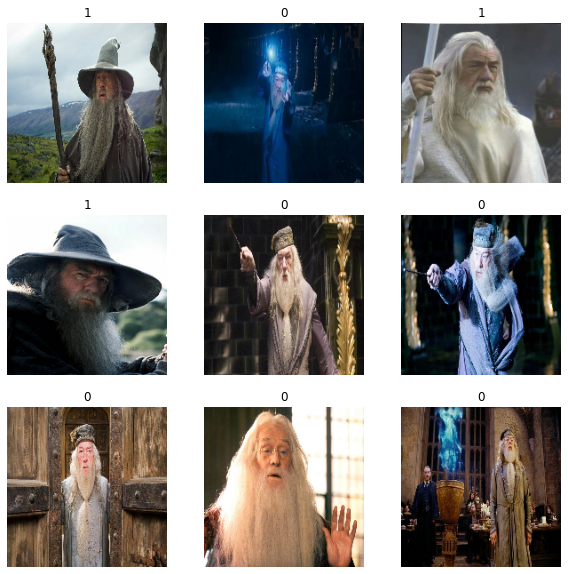

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

#**2. Data Pocessing**

## Using image data augmentation

When you don't have a large image dataset, it's a good practice to artificially
introduce sample diversity by applying random yet realistic transformations to the
training images, such as random horizontal flipping or small random rotations. This
helps expose the model to different aspects of the training data while slowing down
 overfitting.

In [37]:
image_augmentation = keras.Sequential(
    [
        layers.RandomFlip(),
        layers.RandomRotation(factor=0.1),
        layers.RandomContrast(0.01),
        #layers.RandomTranslation(height_factor=0.1, width_factor=0.1, seed=SEED),
        #layers.RandomZoom(0.2, fill_mode='nearest', seed=SEED),
    ],
    name = "image_augmentation"
)

Let's visualize what the augmented samples look like, by applying `data_augmentation`
 repeatedly to the first image in the dataset:

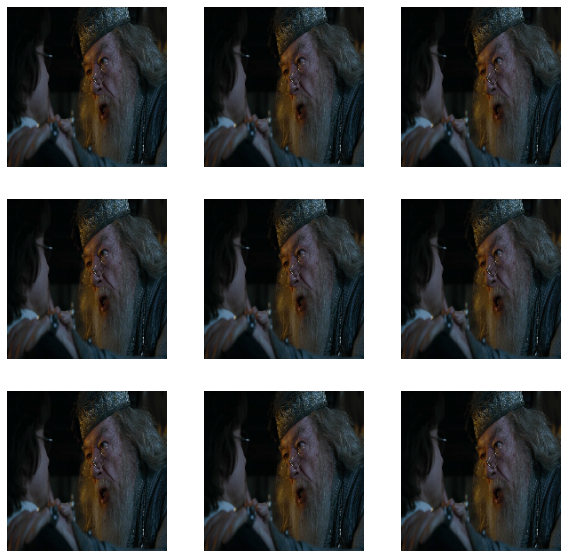

In [38]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = image_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

# **3. Build a model**

## Model

I haven chosen to use the ResNet152 architecture, replacing the top layers to adjust it to our binary classification problem. We have the choise to import either a blank model or a pretrained one, depending on the train parameter. We will shortly see the difference of performance between both options

In [39]:
# ResNet152
from keras.applications.resnet import ResNet152 as Architecture

def build_model(input_shape, num_classes, trained):# Depending on the train parameter, it returns a pre-trained model or not
  base_model = Architecture (include_top=False, input_shape=input_shape, weights='imagenet'if trained else None)
  base_model.trainable = not trained

  inputs = keras.Input(shape=input_shape, name='input')
  x = image_augmentation(inputs)
  x = base_model(x)
  x = layers.GlobalAveragePooling2D(name='avg_pool')(x)
  x = layers.BatchNormalization()(x)
  x = layers.Dropout(0.2,name='top_dropout')(x)
  
  if num_classes == 2:
    activation = 'sigmoid'
    units = 1
  else:
    activation = 'softmax'
    units = num_classes

  outputs = layers.Dense(units,activation=activation, name='pred')(x)
  return keras.Model(inputs, outputs, name=Architecture.__name__)

In [40]:
# function to plot the accuracy
def plot_model_hist(model_history):
    sns.set()
    ig, axs = plt.subplots(1,2, figsize=(15,5))
    # Summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['accuracy'])+1), model_history.history['accuracy'])
    axs[0].plot(range(1,len(model_history.history['val_accuracy'])+1), model_history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['train','val'],loc='best')
    
    # Summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1), model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1), model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['train','val'],loc='best')
    
    plt.show()

## Blanck Model

In this model, the ResNet 152 presents random weights, that is, it does not have pre-trained parameters.

Total parameters: 58,381,185

Trainable parameters: 58,225,665

In [41]:
model = build_model(image_size+(3,), 2, trained=False)
model.summary()

Model: "ResNet152"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 180, 180, 3)]     0         
                                                                 
 image_augmentation (Sequent  (None, 180, 180, 3)      0         
 ial)                                                            
                                                                 
 resnet152 (Functional)      (None, 6, 6, 2048)        58370944  
                                                                 
 avg_pool (GlobalAveragePool  (None, 2048)             0         
 ing2D)                                                          
                                                                 
 batch_normalization_2 (Batc  (None, 2048)             8192      
 hNormalization)                                                 
                                                         

Epoch 1/50
2/2 [==============================] - 127s 54s/step - loss: 4.4609 - accuracy: 0.7188 - val_loss: nan - val_accuracy: 0.5000
Epoch 2/50
2/2 [==============================] - 94s 49s/step - loss: 1.6827 - accuracy: 0.5469 - val_loss: nan - val_accuracy: 0.5000
Epoch 3/50
2/2 [==============================] - 94s 49s/step - loss: 0.8310 - accuracy: 0.5625 - val_loss: nan - val_accuracy: 0.5000
Epoch 4/50
2/2 [==============================] - 93s 49s/step - loss: 0.7864 - accuracy: 0.5156 - val_loss: nan - val_accuracy: 0.5000
Epoch 5/50
2/2 [==============================] - 92s 48s/step - loss: 0.9432 - accuracy: 0.5000 - val_loss: nan - val_accuracy: 0.5000
Epoch 6/50
2/2 [==============================] - 98s 54s/step - loss: 1.6198 - accuracy: 0.4844 - val_loss: nan - val_accuracy: 0.5000
Epoch 7/50
2/2 [==============================] - 95s 49s/step - loss: 1.4286 - accuracy: 0.5312 - val_loss: nan - val_accuracy: 0.5000
Epoch 8/50
2/2 [==============================]

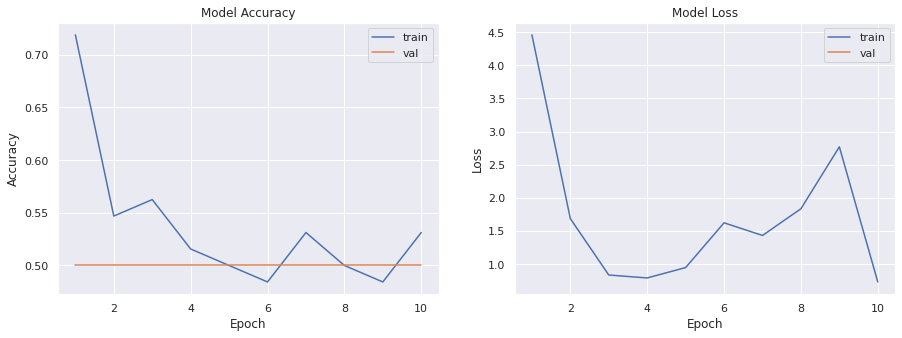

In [50]:
epochs = 50

callbacks = [
    keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
    keras.callbacks.ModelCheckpoint(save_best_only=True, mode='min', filepath='model.hdf5')
]

model.compile(
    optimizer=keras.optimizers.Adam(1e-2),
    loss='binary_crossentropy',
    metrics=['accuracy']
)
history=model.fit(train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds)
plot_model_hist(history)

As we can see, we do not seem to have enough images to train a model a from scracth, resulting in a random model with 50% accuracy on the validation set. Lets see how a pretrained model performs instead

## Pretrained Model

In [45]:
model = build_model(image_size+(3,), 2,trained=True)
model.summary()

Model: "ResNet152"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 180, 180, 3)]     0         
                                                                 
 image_augmentation (Sequent  (None, 180, 180, 3)      0         
 ial)                                                            
                                                                 
 resnet152 (Functional)      (None, 6, 6, 2048)        58370944  
                                                                 
 avg_pool (GlobalAveragePool  (None, 2048)             0         
 ing2D)                                                          
                                                                 
 batch_normalization_3 (Batc  (None, 2048)             8192      
 hNormalization)                                                 
                                                         

Epoch 1/50
2/2 [==============================] - 42s 20s/step - loss: 1.0535 - accuracy: 0.4375 - val_loss: 0.8290 - val_accuracy: 0.6250
Epoch 2/50
2/2 [==============================] - 27s 16s/step - loss: 0.8007 - accuracy: 0.5469 - val_loss: 0.7049 - val_accuracy: 0.5625
Epoch 3/50
2/2 [==============================] - 27s 16s/step - loss: 0.5551 - accuracy: 0.7500 - val_loss: 0.5943 - val_accuracy: 0.6250
Epoch 4/50
2/2 [==============================] - 26s 16s/step - loss: 0.3965 - accuracy: 0.8594 - val_loss: 0.5317 - val_accuracy: 0.6875
Epoch 5/50
2/2 [==============================] - 27s 16s/step - loss: 0.2998 - accuracy: 0.8438 - val_loss: 0.4798 - val_accuracy: 0.6875
Epoch 6/50
2/2 [==============================] - 27s 16s/step - loss: 0.3973 - accuracy: 0.8438 - val_loss: 0.4372 - val_accuracy: 0.8125
Epoch 7/50
2/2 [==============================] - 27s 17s/step - loss: 0.2735 - accuracy: 0.8750 - val_loss: 0.4185 - val_accuracy: 0.8125
Epoch 8/50
2/2 [===========

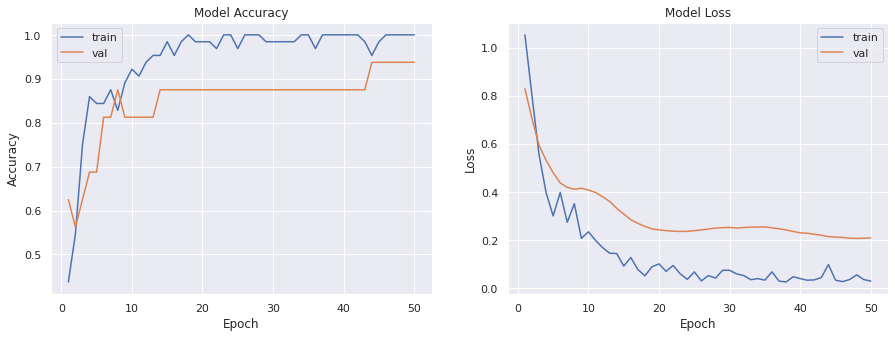

In [46]:
epochs = 50

callbacks = [
    keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True),
    keras.callbacks.ModelCheckpoint(save_best_only=True, mode='min', filepath='petrained_model.hdf5')
]

model.compile(
    optimizer=keras.optimizers.Adam(2e-3),
    loss='binary_crossentropy',
    metrics=['accuracy']
)
history=model.fit(train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds)
plot_model_hist(history)

As we can observe from these results, using a pretrained model allows us to focus on the training the last layer, used for classification while letting to bottom layers frozen. The bottom layers seem to be extracting good features for our top layers to use, but could be do better?

## Fine Turing

We unfreeze the bottom layers of our model and train them, hopefully improving the predicting power of our model

In [47]:
def unfreeze_model(model):
# We unfreeze the top 20 layers while leaving BachtNorm layers frozen
  for layer in model.layers[-20:]:
    if not isinstance(layer, layers.BatchNormalization):
      layer.trainable=True
  return model

In [48]:
model = unfreeze_model(model)
model.summary()

Model: "ResNet152"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 180, 180, 3)]     0         
                                                                 
 image_augmentation (Sequent  (None, 180, 180, 3)      0         
 ial)                                                            
                                                                 
 resnet152 (Functional)      (None, 6, 6, 2048)        58370944  
                                                                 
 avg_pool (GlobalAveragePool  (None, 2048)             0         
 ing2D)                                                          
                                                                 
 batch_normalization_3 (Batc  (None, 2048)             8192      
 hNormalization)                                                 
                                                         

Epoch 1/50
2/2 [==============================] - 28s 18s/step - loss: 0.0387 - accuracy: 1.0000 - val_loss: 0.2090 - val_accuracy: 0.9375
Epoch 2/50
2/2 [==============================] - 25s 15s/step - loss: 0.0494 - accuracy: 0.9844 - val_loss: 0.2113 - val_accuracy: 0.9375
Epoch 3/50
2/2 [==============================] - 25s 15s/step - loss: 0.0586 - accuracy: 0.9844 - val_loss: 0.2138 - val_accuracy: 0.9375
Epoch 4/50
2/2 [==============================] - 25s 15s/step - loss: 0.0599 - accuracy: 0.9844 - val_loss: 0.2169 - val_accuracy: 0.9375
Epoch 5/50
2/2 [==============================] - 25s 15s/step - loss: 0.0456 - accuracy: 0.9688 - val_loss: 0.2187 - val_accuracy: 0.9375
Epoch 6/50
2/2 [==============================] - 25s 15s/step - loss: 0.0363 - accuracy: 1.0000 - val_loss: 0.2198 - val_accuracy: 0.9375
Epoch 7/50
2/2 [==============================] - 25s 15s/step - loss: 0.0432 - accuracy: 0.9844 - val_loss: 0.2209 - val_accuracy: 0.9375
Epoch 8/50
2/2 [===========

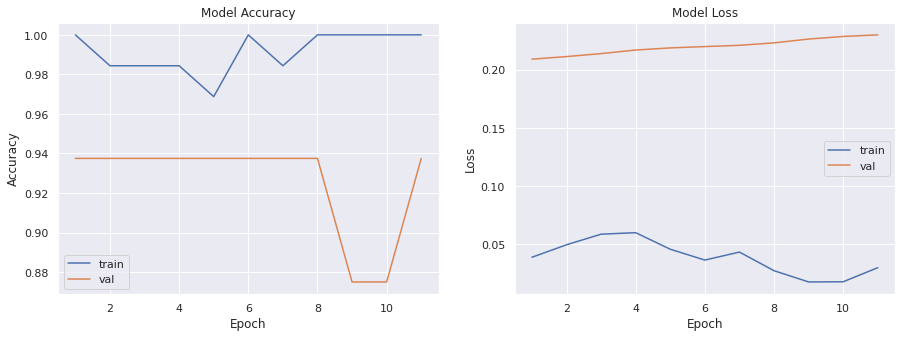

In [49]:
epochs = 50

callbacks = [
    keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
    keras.callbacks.ModelCheckpoint(save_best_only=True, mode='min', filepath='finetunedpetrained_model.hdf5')
]
history=model.fit(train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds)
plot_model_hist(history)